<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/keras_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series estimation with Deep Learning

Mottó: a jóslás nehéz műfaj, főleg a jövőre vonatkozó.

TODO karas.layer.LSTM https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb#scrollTo=nXbQUIn6-yO-

## Prepearing data

We use death data in Hungary from 2015 to 2024. Data were downloaded from the Central Statistics Office of Hungary. We will consider it as an univariate serie.

Let's have the data as a pandas data frame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# adatok betöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])

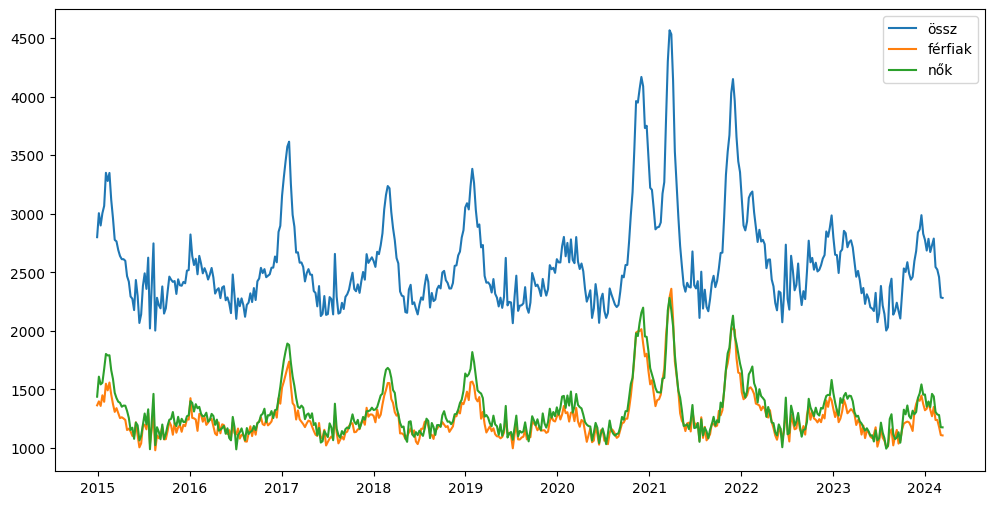

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df['start'], df['all_total'], label='össz')
plt.plot(df['start'], df['man_total'], label='férfiak')
plt.plot(df['start'], df['woman_total'], label='nők')
plt.legend()

## Using Keras and 1D convolutional neural network

Autoregressive method for short term prediction using temporal convolutional network.

In [48]:
from numpy import zeros, mean, array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM

In [5]:
# split a univariate sequence into samples
def split_sequence(seq, n_steps):
	sequence = seq.to_numpy()
	n = sequence.shape[0]
	X = zeros((n - n_steps, n_steps))
	y = sequence[n_steps:]
	for i in range(n-n_steps):
		X[i] = sequence[i:i+n_steps]
	return X, y

In [6]:
# define input sequence
raw = df.loc[df['start'] <= '2024-01-01']
raw_seq = raw['all_total']
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [7]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
# fit model
hist = model.fit(X, y, epochs=1000, verbose=0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3493 (13.64 KB)
Trainable params: 3493 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

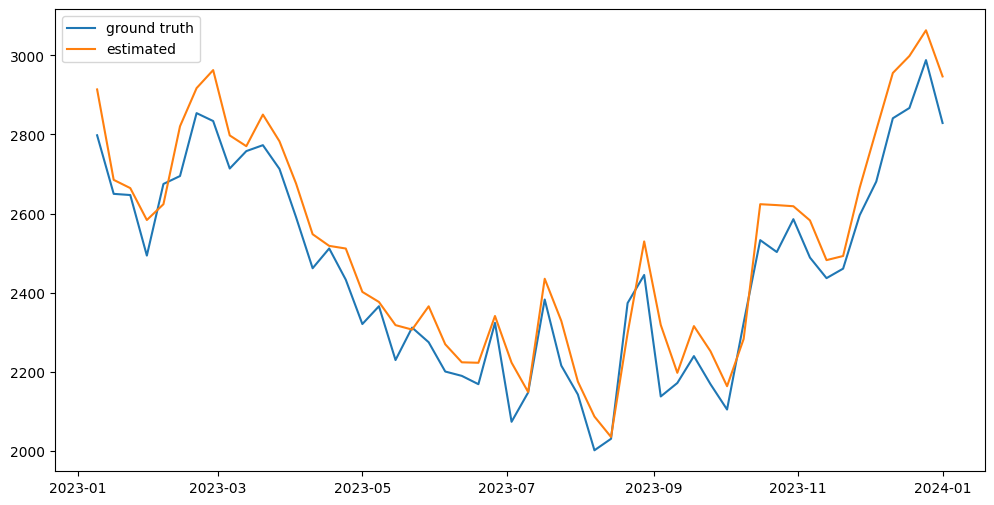

In [8]:
# predict values from model
y_pred = model.predict(X, verbose=0)
plt.figure(figsize=(12,6))
plt.plot(raw["start"][-52:], y[-53:-1], label='ground truth')   # TODO one week shift!
plt.plot(raw["start"][-52:], y_pred[-52:], label='estimated')
plt.legend()

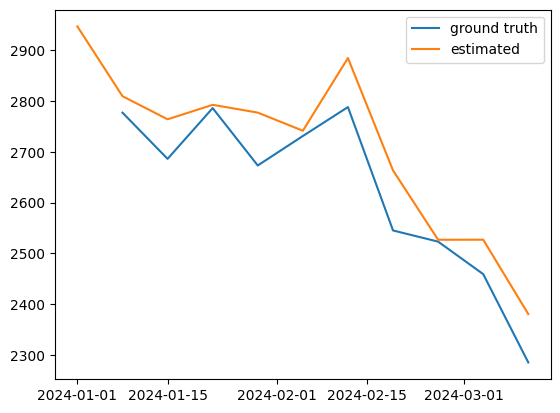

In [9]:
# make estimation for 2024 data
test = df.loc[df['start'] >= '2023-12-11']
test_seq = test['all_total']
X_test, y_test = split_sequence(test_seq, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test_pred = model.predict(X_test, verbose=0)
plt.plot(test['start'][-y_test.shape[0]+1:], y_test[:-1], label='ground truth')
plt.plot(test['start'][-y_test.shape[0]:], y_test_pred, label='estimated')
plt.legend()

In [10]:
# mean prediction error
mfe_train = mean(y[:-1] - y_pred[1:])
print(f"Mean prediction error for train: {mfe_train:.1f}")
mfe_test = mean(y_test[:-1] - y_test_pred[1:])
print(f"Mean prediction error for  test: {mfe_test:.1f}")

Mean prediction error for train: -63.7
Mean prediction error for  test: -61.3


## Recurrent

In [58]:
XX = raw_seq.to_numpy().reshape(157, n_steps, 1)[1:].astype('float32')
#XX.reshape(157, 3, 1)
yy = y[::n_steps].astype('float32')

XX.shape, yy.shape, XX.dtype

((156, 3, 1), (156,), dtype('float32'))

In [59]:
#RNN
#lstm_model = Sequential()
#lstm_model.add(LSTM(32, return_sequences=True))
#lstm_model.add(Dense(1))
from keras.layers import Input
from keras.models import Model

inputs = Input(shape=(n_steps,1))
lstm = LSTM(50, activation="relu")(inputs)
outputs = Dense(1)(lstm)

lstm_model = Model(inputs, outputs)

lstm_model.compile(optimizer='adam', loss='mse')


#lstm_model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
# fit model
hist =lstm_model.fit(XX, yy, epochs=1000, verbose=0)
lstm_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 50)                10400     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
XXX = X_test[-1].reshape(1,n_steps,1)
print(XXX.shape)
y_lstm_test_pred = lstm_model.predict(XXX, verbose=0)
y_lstm_test_pred

(1, 3, 1)


array([[2524.8145]], dtype=float32)

In [ ]:
XXX = raw_seq.to_numpy()
XXX.shape

In [63]:
y_lstm_pred = lstm_model.predict(X, verbose=0)

In [64]:
y_lstm_test_pred

array([[2798.3093],
       [3007.9788],
       [2901.4348],
       [3010.217 ],
       [3065.6804],
       [3352.3975],
       [3277.0142],
       [3348.3362],
       [3118.536 ],
       [2963.361 ],
       [2776.6401],
       [2764.2417],
       [2690.5122],
       [2639.8372],
       [2612.4963],
       [2610.6572],
       [2598.4604],
       [2465.792 ],
       [2420.8286],
       [2292.1016],
       [2279.1216],
       [2174.3643],
       [2431.4382],
       [2300.6858],
       [2071.1406],
       [2142.3555],
       [2381.0662],
       [2496.5066],
       [2347.7827],
       [2633.8464],
       [2025.0852],
       [2335.7356],
       [2755.1704],
       [2000.4047],
       [2282.3792],
       [2223.7026],
       [2188.0857],
       [2381.2515],
       [2149.633 ],
       [2194.1396],
       [2331.6887],
       [2463.4568],
       [2437.8406],
       [2416.84  ],
       [2428.0945],
       [2314.3008],
       [2440.7866],
       [2390.1848],
       [2385.3127],
       [2420.4404],


## Using XGBoost

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [ ]:
# adatok betöltése
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/weekly_death.csv
df = pd.read_csv('weekly_death.csv', parse_dates=['start', 'end'])
# feature creation
df['quarter'] = df['start'].dt.quarter
df['month'] = df['start'].dt.month
df['julian'] = pd.DatetimeIndex(df['start']).to_julian_date()

FEATURES = ['julian', 'year', 'quarter', 'month', 'week']
TARGET = 'all_total'

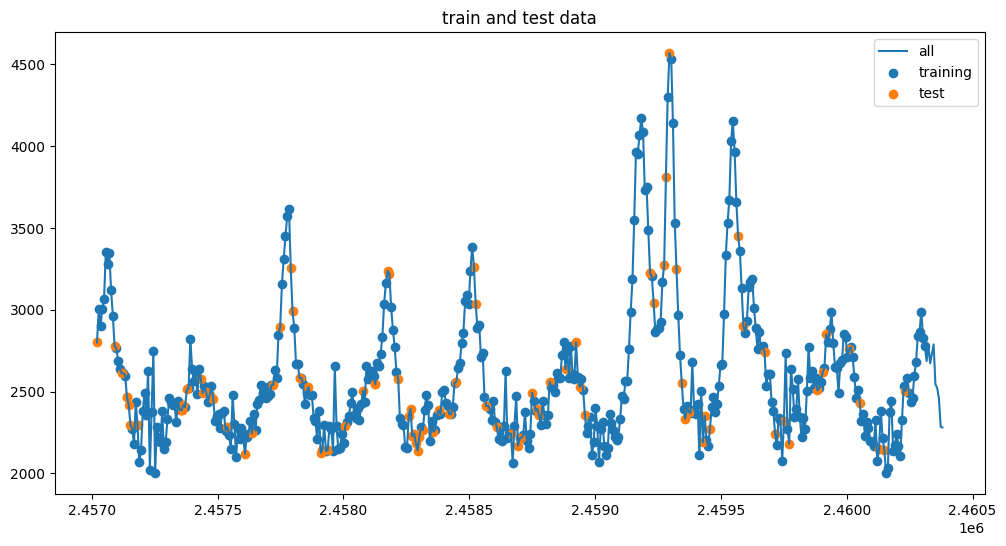

In [ ]:
# split data into train and test set
raw = df.loc[df['start'] <= '2024-01-01']
raw_seq = raw['all_total']
X = raw[FEATURES].to_numpy()
y = raw_seq.to_numpy()
n = y.shape[0]
indx = np.random.randint(n, size=int(0.2*n))   # véletlen indexek teszt adatokhoz
X_test = X[indx]; y_test = y[indx]
mask = np.ones(n, dtype=bool)
mask[indx] = False
X_train = X[mask]; y_train = y[mask]
plt.figure(figsize=(12,6))
plt.plot(df['julian'], df['all_total'], label='all')
plt.scatter(X_train[:,0], y_train, label='training')
plt.scatter(X_test[:,0], y_test, label='test')
plt.legend()
_ = plt.title("train and test data")

In [ ]:
sc = StandardScaler()
sc.fit(X)   # normalizálás paraméterei
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [ ]:
# create model and fit
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=100,
                       objective= 'reg:squarederror', #'reg:linear',
                       max_depth=9,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2596.60870	validation_1-rmse:2563.01691
[100]	validation_0-rmse:991.38652	validation_1-rmse:975.30294
[200]	validation_0-rmse:407.61718	validation_1-rmse:399.74694
[300]	validation_0-rmse:190.04144	validation_1-rmse:199.27855
[400]	validation_0-rmse:104.62728	validation_1-rmse:143.15640
[500]	validation_0-rmse:68.10231	validation_1-rmse:130.71866
[600]	validation_0-rmse:51.37139	validation_1-rmse:130.40659
[627]	validation_0-rmse:48.47677	validation_1-rmse:131.06617


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

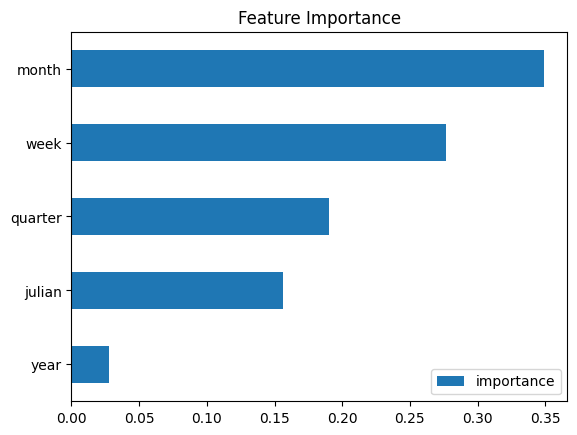

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=FEATURES,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
# estimate future data
raw = df.loc[df['start'] >= '2024-01-01']
raw_seq = raw['all_total']
X_new = raw[FEATURES].to_numpy()
y_new_pred = reg.predict(X_new)

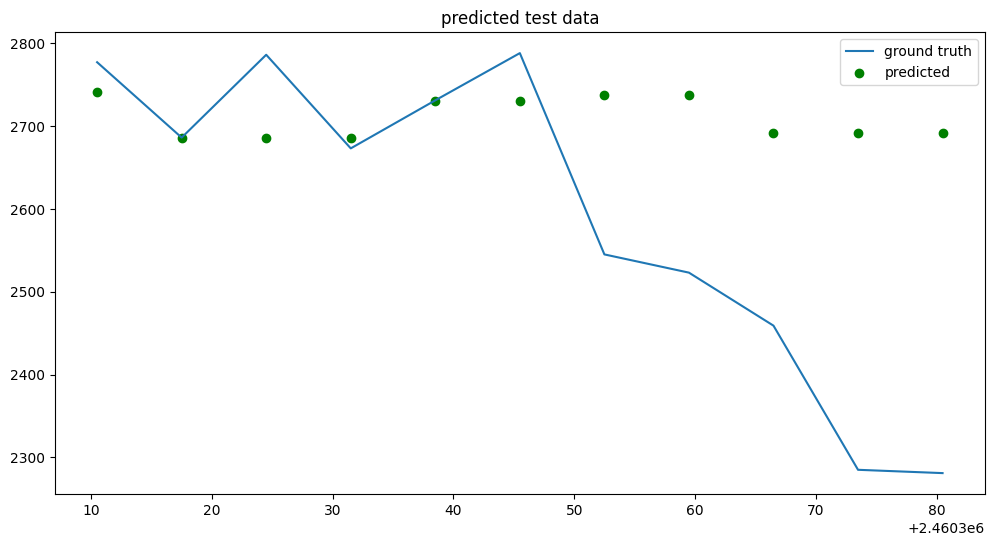

In [ ]:
y_pred = reg.predict(X_test)
plt.figure(figsize=(12,6))
#plt.plot(X[:,0], y, label='ground true')
plt.plot(raw['julian'], raw['all_total'], label='ground truth')
#plt.scatter(X_test[:,0], y_pred[], c='red', label='predicted')
plt.scatter(X_new[:,0], y_new_pred, c='green', label='predicted')
plt.legend()
_ = plt.title("predicted test data")